# Introduction

<font color='Blue' size=3>There are certain movies (could be anything) that some people like, and certain movies that they don't. Based on their movie ratings, a recommender system can be implemented to suggest other movies that they may like.<br>
<br>
To demonstrate this, I will use the dataset from [MovieLens](https://grouplens.org/datasets/movielens/), where users have rated on some movies.</font>

In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Data Analysis

<font color='Blue' size=3>Let's see the first few elements of the data. There are 4 columns: userId, movieId, rating, and timestamp.</font>

In [2]:
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


<font color='Blue' size=3>Let's merge movie titles and genres into the data frame.</font>

In [3]:
df_movie = pd.read_csv('ml-latest-small/movies.csv')
df = pd.merge(df_movie,df_ratings)
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091


<font color='Blue' size=3>Let's inspect the patern of how the users rated the movies.</font>

In [4]:
df.groupby('userId').agg({'rating':[np.size,np.mean]}).describe()

rating            
              size        mean
count   671.000000  671.000000
mean    149.037258    3.657587
std     231.226948    0.471339
min      20.000000    1.333333
25%      37.000000    3.396193
50%      71.000000    3.675000
75%     161.000000    3.984026
max    2391.000000    4.948718

<font color='Blue' size=3>There are 671 users. On average, a user rated 149 movies. The average rating given by a user is around 3.7.</font>

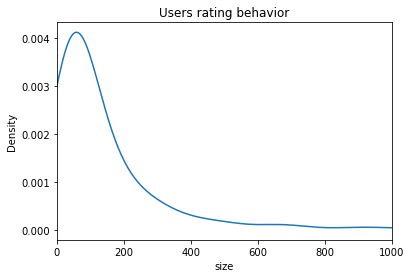

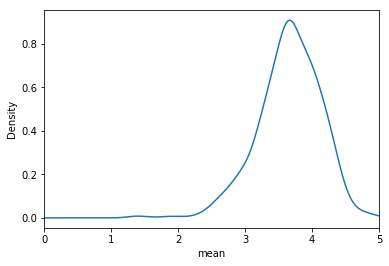

In [5]:
df.groupby('userId').agg({'rating':[np.size,np.mean]})['rating']['size'].plot.density()
plt.title('Users rating behavior')
plt.xlim(0,1000)
plt.xlabel('size')
plt.show()
df.groupby('userId').agg({'rating':[np.size,np.mean]})['rating']['mean'].plot.density()
plt.xlim(0,5)
plt.xlabel('mean')
plt.show()

<font color='Blue' size=3>Let's inspect the patern of how the movies are rated.</font>

In [6]:
df.movieId.value_counts()[:10]

356     341
296     324
318     311
593     304
260     291
480     274
2571    259
1       247
527     244
589     237
Name: movieId, dtype: int64

In [7]:
df.groupby('movieId').agg({'rating':[np.size,np.mean]}).describe()

rating             
              size         mean
count  9066.000000  9066.000000
mean     11.030664     3.292054
std      24.050800     0.881968
min       1.000000     0.500000
25%       1.000000     2.843750
50%       3.000000     3.500000
75%       9.000000     3.966250
max     341.000000     5.000000

<font color='Blue' size=3>There are 9066 movies being rated. The average number of ratings and the average rating received for each movie is 11 and 3.3. More than 75% of the movies have less than 10 number of ratings.</font>

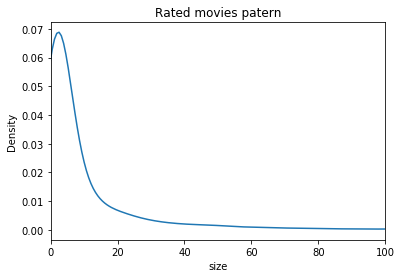

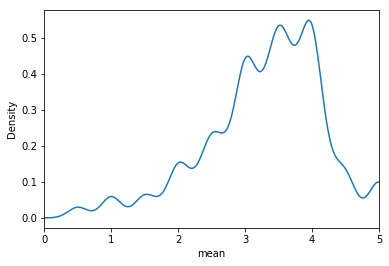

In [8]:
df.groupby('movieId').agg({'rating':[np.size,np.mean]})['rating']['size'].plot.density()
plt.title('Rated movies patern')
plt.xlim(0,100)
plt.xlabel('size')
plt.show()
df.groupby('movieId').agg({'rating':[np.size,np.mean]})['rating']['mean'].plot.density()
plt.xlim(0,5)
plt.xlabel('mean')
plt.show()

<font color='Blue' size=3>Let's find the most popular movies!</font>

In [9]:
df.groupby('title').agg({'rating':[np.size,np.mean]}).sort_values([('rating','mean')],ascending=False)[:5]

rating     
                                                     size mean
title                                                         
Ivan Vasilievich: Back to the Future (Ivan Vasi...    1.0  5.0
Alien Escape (1995)                                   1.0  5.0
Boiling Point (1993)                                  1.0  5.0
Bone Tomahawk (2015)                                  1.0  5.0
Borgman (2013)                                        1.0  5.0

<font color='Blue' size=3>These movies have 5/5 rating, but only has one number of rating, which does not represent the popularity of the movies.<br>

Let's only consider movies with at least 100 number of ratings.</font>

In [10]:
at_least = df.groupby('title').agg({'rating':[np.size,np.mean]})['rating']['size'] >= 100

In [11]:
df.groupby('title').agg({'rating':[np.size,np.mean]})[at_least].sort_values([('rating','mean')],ascending=False)[:5]

rating          
                                   size      mean
title                                            
Godfather, The (1972)             200.0  4.487500
Shawshank Redemption, The (1994)  311.0  4.487138
Godfather: Part II, The (1974)    135.0  4.385185
Usual Suspects, The (1995)        201.0  4.370647
Schindler's List (1993)           244.0  4.303279

<font color='Blue' size=3>Here's the top 5 most popular movies with at least 100 number of ratings. The highest (mean) rating is 4.5.</font>

# Collaborative Filtering Recommender System

<font color='Blue' size=3>After the data analysis, let's implement some recommendation systems.<br>
<br>
There are primarily two types of recommender systems, i.e. collaborative filtering (CF) and content-based recommation.<br>
CF adopts users attitutes towards the items, while content-based recommender focuses on the item's attributes and make suggestions based on item similarities.<br>
<br>
We will focus on CF. There are a few models associated with CF, and I'll compare using k-Nearest Neighbours (kNN) and matrix factorization.<br>
kNN looks for clusters of similar users based on common ratings and make predictions using the average rating of top k-th nearest neighbours. On the other hand, matrix factorizarion find the interactions between users and items by decomposing large matrices, hence make this method more powerful.<br>
<br>
Let's do this in the Surprise framework.</font>

In [4]:
from surprise import SVD, Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import cross_validate

In [5]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df[['userId','movieId','rating']], reader=reader)

## k-Nearest Neighbours

<font color='Blue' size=3>Let's start with kNN using cosine similarity.</font>

In [ ]:
algo_kNN = KNNBasic(sim_options = {'name':'cosine', 'user_based': False})
cross_validate(algo_kNN, data, measures=['RMSE','MAE'], cv = 5, verbose = True)

Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...


<font color='Blue' size=3>RMSE and MAE of 5-fold CV using kNN are 1.0 and 0.8.</font>

## Matrix Factorization (Single Value Decomposition)

<font color='Blue' size=3>Let's switch to matrix factorization. One model is the single value decomposition (SVD).</font>

In [6]:
algo_SVD = SVD()
cross_validate(algo_SVD, data, measures=['RMSE','MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8886  0.8998  0.8964  0.8944  0.9061  0.8971  0.0058  
MAE (testset)     0.6840  0.6926  0.6882  0.6897  0.6970  0.6903  0.0044  
Fit time          5.55    5.42    5.53    5.62    4.81    5.39    0.30    
Test time         0.29    0.29    0.28    0.26    0.21    0.26    0.03    


{'fit_time': (5.554055452346802,
  5.419469356536865,
  5.5320143699646,
  5.620653867721558,
  4.80621600151062),
 'test_mae': array([ 0.68398288,  0.69263599,  0.68822887,  0.68971431,  0.69701652]),
 'test_rmse': array([ 0.88861112,  0.89978572,  0.89642568,  0.89444454,  0.90607793]),
 'test_time': (0.28605175018310547,
  0.28593921661376953,
  0.27620959281921387,
  0.25815391540527344,
  0.20998764038085938)}

<font color='Blue' size=3>RMSE and MAE of 5-fold CV using SVD are 0.9 and 0.7, which is slightly better than kNN as expected.</font>

<font color='Blue' size=3>From our previous data analysis, a user on average rated 149 movies. Since there are about 160k movies in the dataset, so most of the movies are not rated by the users, in other words, the user-by-item matrix is pretty empty. So we can use SVD to predict the ratings for the other movies that a user has not seen, and output the few movies with highest ratings, hence the birth of our recommendation system.</font>

In [7]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [8]:
algo = SVD()
algo.fit(trainset)

In [9]:
prediction = algo.test(testset)

In [10]:
prediction[:3]

[Prediction(uid=7, iid=2, r_ui=3.5436082556697732, est=3.2640764199573726, details={'was_impossible': False}),
 Prediction(uid=7, iid=3, r_ui=3.5436082556697732, est=2.8201957111651885, details={'was_impossible': False}),
 Prediction(uid=7, iid=4, r_ui=3.5436082556697732, est=2.4435826762767694, details={'was_impossible': False})]

In [11]:
accuracy.rmse(prediction, verbose=True)

RMSE: 0.4808


0.48080883176381695

In [12]:
n = 10
top_n = defaultdict(list) # Create a pseudo list
for uid, iid, r_ui, est, _ in prediction:
    top_n[uid].append((iid,est))
for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse = True)
    top_n[uid] = user_ratings[:n]

In [13]:
for uid, user_ratings in top_n.items():
    if uid == 1:
        #print(uid, [iid for (iid, _) in user_ratings])
        [print(df_movie.query('movieId=='+str(i)).title.values) for i in [iid for (iid, _) in user_ratings]]

['Godfather, The (1972)']
['Shawshank Redemption, The (1994)']
['Band of Brothers (2001)']
['City of God (Cidade de Deus) (2002)']
['Princess Mononoke (Mononoke-hime) (1997)']
['Fargo (1996)']
['Godfather: Part II, The (1974)']
['Smoke (1995)']
['Third Man, The (1949)']
['Strangers on a Train (1951)']


<font color='Blue' size=3>These are the top 10 movies recommended for user 1.</font>